# Sinkhorn in all flavors

We provide in this example a detailed walk-through some of the functionalities of the ``sinkhorn`` algorithm, including the computation of ``sinkhorn_divergence``. This [colab](https://colab.research.google.com/drive/1uCK_qBpOb8yY32ABU_GcykSKE-Q-yjfi#scrollTo=zsekRny9wZoI) has all you need to recreate all plots.

In [ ]:
import ott
from ott.tools.sinkhorn_divergence import sinkhorn_divergence
from ott.core.sinkhorn import sinkhorn
from ott.geometry.pointcloud import PointCloud

## From Texts to Word Histograms


We adapt a [keras NLP tutorial](https://keras.io/examples/nlp/pretrained_word_embeddings/) to preprocess raw text (here a subset of 40 texts from the [newsgroup20](https://kdd.ics.uci.edu/databases/20newsgroups/20newsgroups.html) database) and turn them into point clouds of [Glove](http://nlp.stanford.edu/data/glove.6B.zip) word embeddings. More precisely, we recover $N$ histograms of size $2605$ (the size of the union of the sets of all words in the vocabulary of the 40 texts) that have embeddings. These histograms are relatively sparse.

In [ ]:
HIST = texts_to_embedding_measures(samples) # 40 Histograms of size 2605
X = jnp.array(tf.boolean_mask(embedding_matrix, embedding_exists, axis=0)) # embeddings for all 2605 words.

## Pairwise Sinkhorn Divergences

We start by defining a `jitted` version of the `sinkhorn_divergence` using a double `vmap` to compute in one go the pairwise *matrix* of sinkhorn divergence between two sets of histograms. Jitting is super important to achieve efficiency, don't forget to wrap whatever you to with a `jax.jit` if you want to run at scale.

In [ ]:
sink_div = jax.jit(jax.vmap(
    lambda HIST_1, HIST_2, X, epsilon: jax.vmap(
        lambda hist_1, hist_2, X, epsilon : sinkhorn_divergence(
            PointCloud, X, X, epsilon=epsilon, a=hist_1, b=hist_2).divergence,
        in_axes=[0, None, None, None])(HIST_1, HIST_2, X, epsilon),
    in_axes=[None, 0, None,None]))

Before setting a value for `epsilon`, let's get a feel of what the point cloud of embeddings looks like in terms of distances.

In [ ]:
geom = PointCloud(X,X)
print('median:', geom.median_cost_matrix, ' mean:', geom.mean_cost_matrix, ' max:', jnp.max(geom.cost_matrix))

median: 0.6980109  mean: 0.70522994  max: 2.5196552


When setting `epsilon` to `None`, the algorithms will default to 1/20th of the mean distance, namely

In [ ]:
print('Default epsilon is: ', geom.epsilon)

Default epsilon is:  0.035261497


Let's compute a $20 \times 20$ pairwise matrix of sinkhorn divergences. We first divide the set of texts in 2.

In [ ]:
HIST_a = jnp.array(HIST[0:20])
HIST_b = jnp.array(HIST[20:])

Dry run with large epsilon value to force jit compilation before computing timings. This only makes sense within this tutorial.

In [ ]:
DIV = sink_div(HIST_a, HIST_b, X, 1000)

We now carry out divergence computations and plot their matrix for various `epsilon`. Notice how smaller `epsilon` directly impact both time (shorter) and discriminative power. As `epsilon` grows, the `sinkhorn_divergence` converges to what is otherwise known as the MMD. 

In [ ]:
DIV, ran_in = [] , []
epsilons = [None, 5e-2, 1e-1, 1]
for epsilon in epsilons:  
  tic = time.perf_counter()
  DIV.append(sink_div(HIST_a, HIST_b, X, epsilon).block_until_ready())
  toc = time.perf_counter()
  ran_in.append(toc - tic)

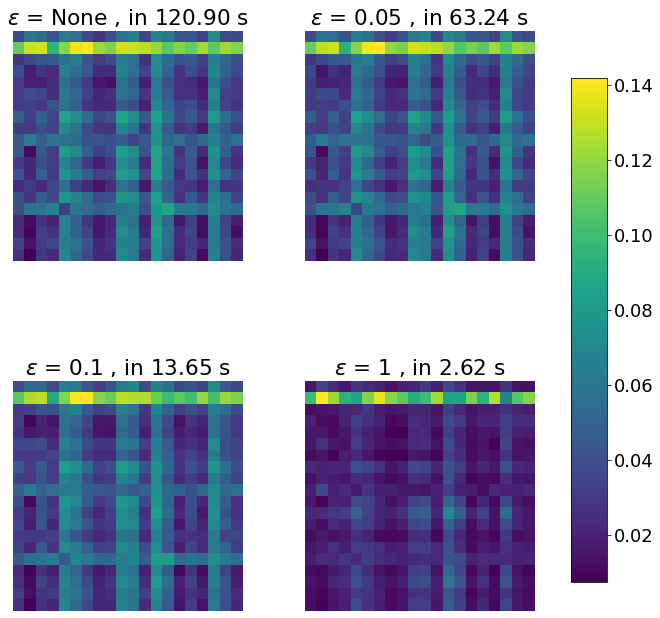

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.tight_layout()
axes= [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]

for epsilon, DIV_, ran_in_, ax_ in zip(epsilons, DIV, ran_in, axes):
  im = ax_.imshow(DIV_)
  ax_.set_title(r'$\varepsilon$ = ' + str(epsilon) + f' , in {ran_in_:.2f} s')
  ax_.axis('off')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

## $\varepsilon$ and momentum

We study in more detail how `epsilon` can impact the convergence of the algorithm. We create a (jitted) handle for the simple computation of `sinkhorn` between two histograms.

In [ ]:
sinkorn_fun = jax.jit(
    lambda a, b, X, epsilon : sinkhorn(
        PointCloud(X, X, epsilon=epsilon),
        inner_iterations=1, # recomputing error every iteration for plots.
        a=a, b=b))

a, b = HIST_a[0], HIST_b[-1]
# Another dry run to force jit compilation.
_ = sinkorn_fun(a, b, X, 1000)

Using the first and last histogram of each respective set, let's take a closer look at the output of `sinkhorn` for various `epsilon` values, notably that selected by default:

In [ ]:
out_eps , leg_eps = [], []
epsilons = [1e-3, 1e-2, None, 1e-1]
ran_in = np.zeros((len(epsilons),))
for i, eps in enumerate(epsilons):
  tic = time.perf_counter()  
  out_eps.append(sinkorn_fun(a, b, X, eps))
  toc = time.perf_counter()
  ran_in[i] = toc - tic  
  leg_eps.append(r'$\varepsilon$' + f'= {eps}, cost = {out_eps[-1].reg_ot_cost:.2f}')

These execution times can then be plotted, to result in the following graph

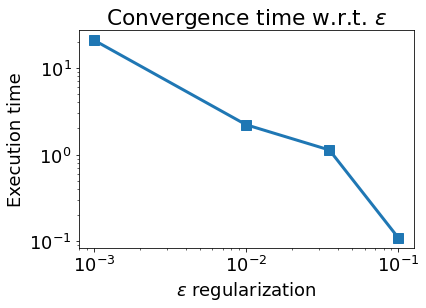

In [ ]:
epsilons[2] = geom.epsilon  # replace 'None' option with actual value
plt.plot(epsilons, ran_in, marker='s', markersize=10, linewidth=3)
plt.title(r'Convergence time w.r.t. $\varepsilon$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\varepsilon$ regularization')
plt.ylabel('Execution time')
plt.show()

Using a `plot_results` function (again, see [colab](https://colab.research.google.com/drive/1uCK_qBpOb8yY32ABU_GcykSKE-Q-yjfi#scrollTo=zsekRny9wZoI) for details) we can see that the convergence is naturally impacted by `epsilon`. There is therefore a tradeoff between speed and how close to the original Wasserstein you want to be.  If you have no strong opinion on how to set ``epsilon``, larger ``epsilon`` values are a sure bet since this makes your life substantially easier.

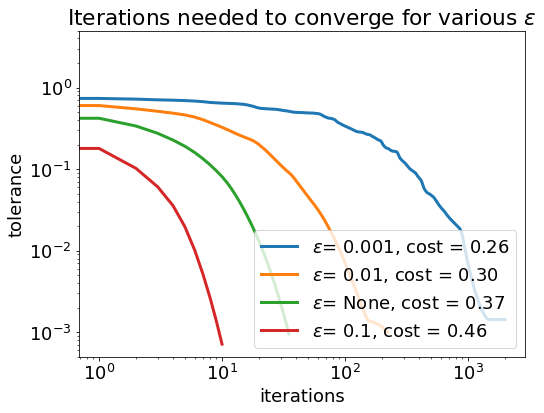

In [ ]:
plot_results(out_eps, leg_eps, title=r'Iterations needed to converge for various $\varepsilon$', xlabel='iterations', ylabel='tolerance')

[Thibault et al.](https://arxiv.org/abs/1711.01851) proposed to use a momentum term to (hopefully) accelerate the convergence of the Sinkhorn algorithm. This can be used by modifying the `momentum_strategy` parameter. We test various values here in the setting with varying `epsilon`. As can be seen below, it might be helpful to use a momentum larger than 1.0 (also known as extrapolation or overrelaxation) to accelerate convergence a bit. 

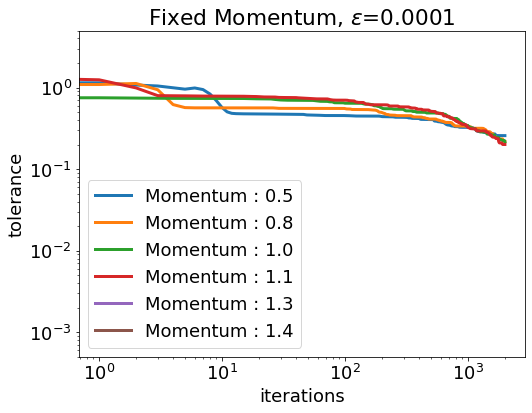

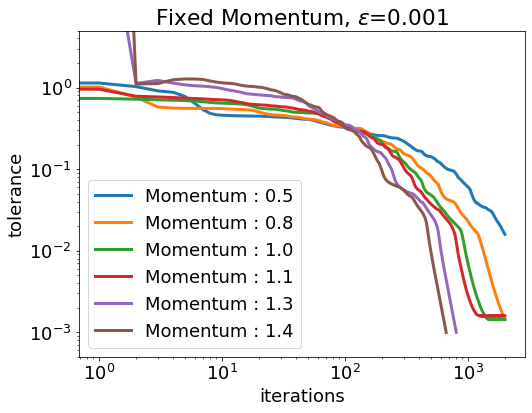

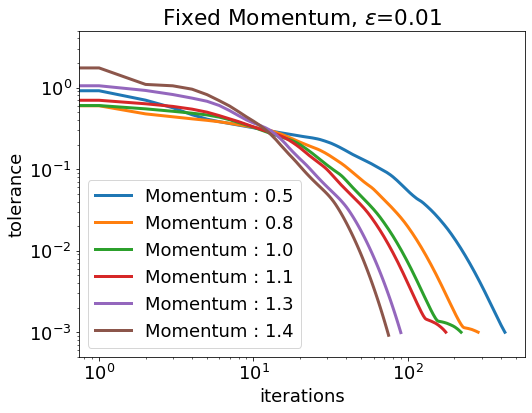

In [ ]:
for epsilon in [1e-4, 1e-3, 1e-2]:
  out_mom , leg_mom = [], []
  for mom in [.5, .8, 1.0, 1.1, 1.3, 1.4]:  
    out_mom.append(sinkhorn(PointCloud(X, X, epsilon=epsilon),
                            inner_iterations=1, momentum=mom,
                            a=a, b=b, jit=True))            
    leg_mom.append(f'Momentum : {mom}')
  plot_results(out_mom, leg_mom, 'lower left', title = r'Fixed Momentum, $\varepsilon$=' + str(epsilon), xlabel='iterations', ylabel='tolerance')

The following [paper](https://arxiv.org/pdf/2012.12562v1.pdf) proposes a simple rule to update the momentum term adaptively, after a few Sinkhorn iterations. We test this approach again with various `epsilon` values. It seems that for all regularization strengths choosing to change the momentum adaptively resuls in faster convergence.

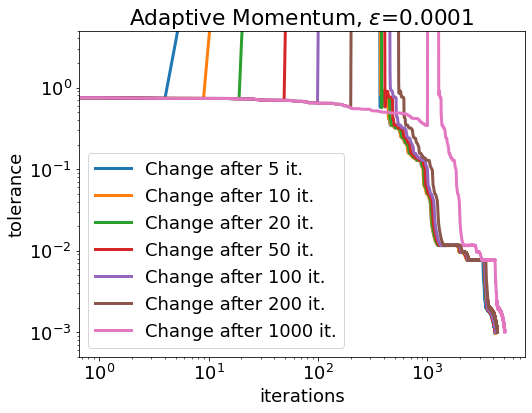

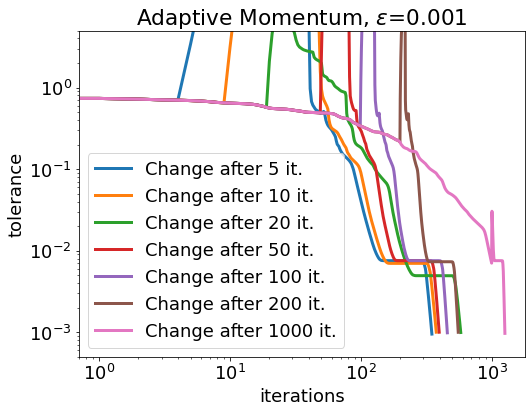

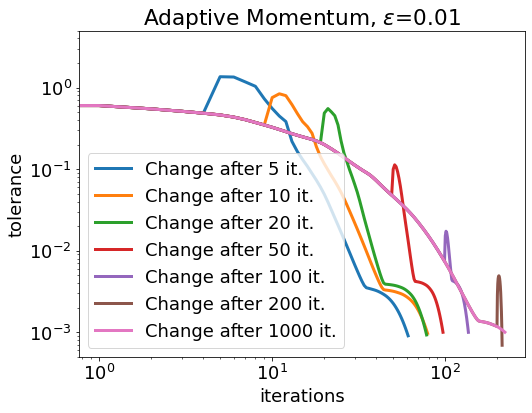

In [ ]:
for epsilon in [1e-4, 1e-3, 1e-2]:
  out_chg_mom , leg_chg_mom = [], []
  for chg_mom in [5, 10, 20, 50, 100, 200, 1000]:  
    out_chg_mom.append(sinkhorn(PointCloud(X, X, epsilon=epsilon),
                          inner_iterations=1,
                          chg_momentum_from=chg_mom,
                          max_iterations=10000,
                          a=a, b=b, jit=True))            
    leg_chg_mom.append(f'Change after {chg_mom} it.')
  plot_results(out_chg_mom, leg_chg_mom, 'lower left', title = r'Adaptive Momentum, $\varepsilon$=' + str(epsilon), xlabel='iterations', ylabel='tolerance')